/home/amarsrinivas/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/amarsrinivas/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Total FFB Relevant Obs: 2843
FFB Obs > 0: 1737
FFB Obs >= 25%: 1510


/home/amarsrinivas/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/amarsrinivas/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


All - Mean Absolute Error CI: [0.22322482 0.40970962 0.59573503]
FFB - Mean Absolute Error CI: [1.24164615 1.49173408 1.73373197]


/home/amarsrinivas/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/amarsrinivas/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/amarsrinivas/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/amarsrinivas/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/amarsr

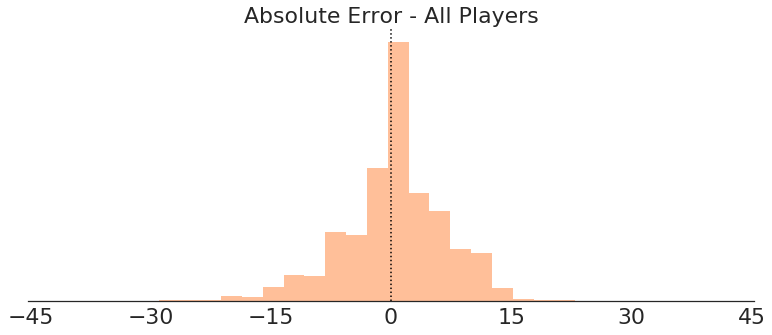

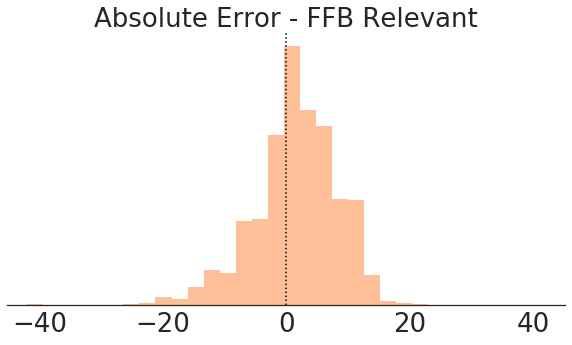

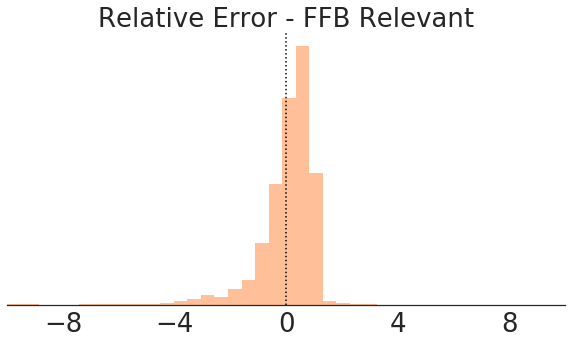

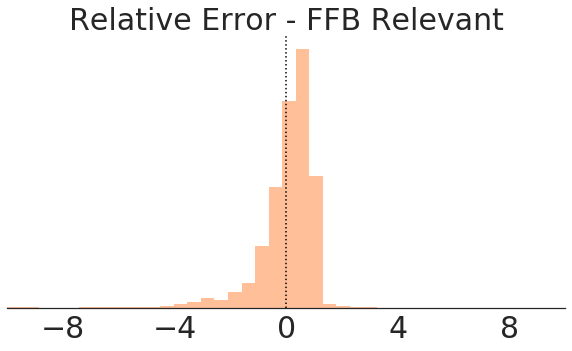

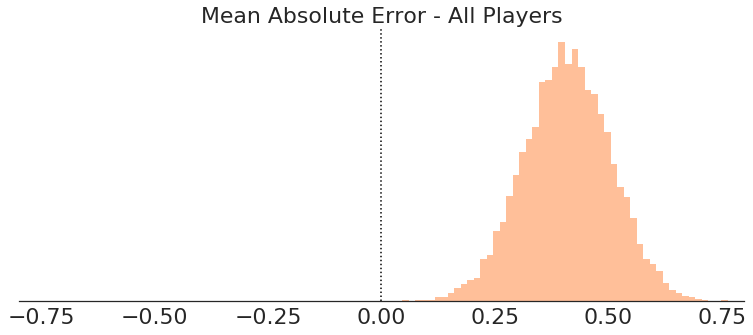

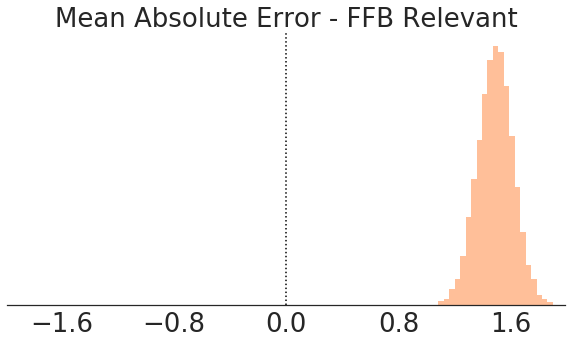

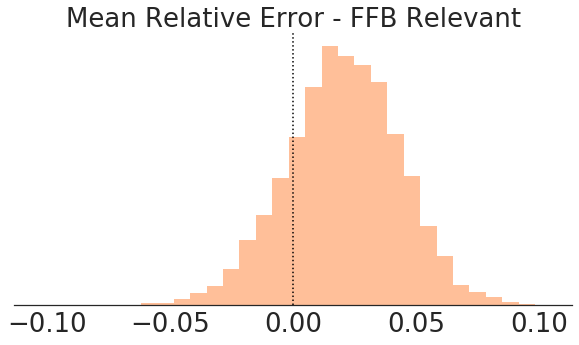

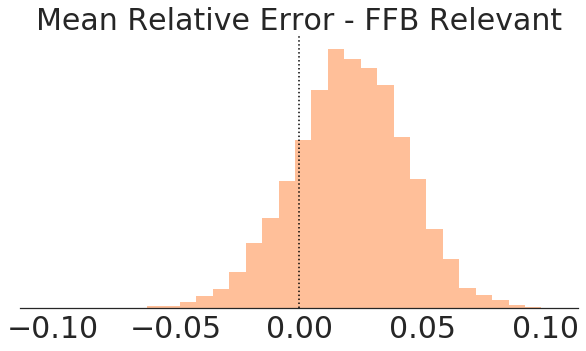

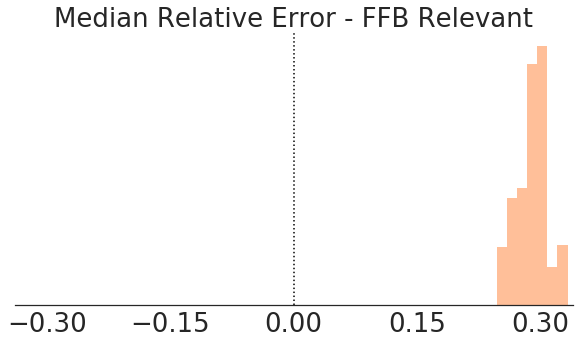

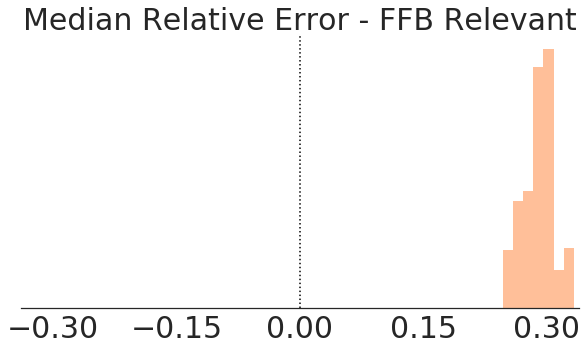

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import json
sns.set(style='white', palette='muted')

def ranker(df):
    """Used for getting the top N players at a given position and week"""
    df.sort_values('projected_pts', inplace=True, ascending=False)
    df['position_rank'] = np.arange(len(df)) + 1
    return df

def bootstrap(data, statfunction=np.mean):
    """Returns a Series of 10,000 boostrapped values with the given statfunction applied"""
    np.random.seed(42)
    samples = pd.DataFrame(np.random.choice(data, size=(10000, len(data)), replace=True))
    return samples.apply(statfunction, axis=1)

def run_player_bootstraps(df):
    """
    Runs the bootstrap function for every player in the given DataFrame.
    Returns
    -------
    {
        Peyton Manning: {
            points: { mean: [], median: [] },
            relative: { mean: [], median: [] }
        }, 
        Matt Forte: {
            points: { mean: [], median: [] },
            relative: { mean: [], median: [] }
        } ...
    }
    """
    players = {}
    for player in df.name.unique().tolist():
        print('Bootstrapping for {}'.format(player))
        cond = df.name == player
        players[player] = {
            'points': {
                'mean': bootstrap(df[cond].point_diff).tolist(),
                'median': bootstrap(df[cond].point_diff, np.median).tolist()
            },
            'relative': {
                'mean': bootstrap(df[cond].relative_diff).tolist(),
                'median': bootstrap(df[cond].relative_diff, np.median).tolist()
            }
        }
    return players

def run_weekly_bootstraps(df):
    """
    Runs the bootstrap function for every week in the given DataFrame.
    Returns
    -------
    {
        1: {
            points: { mean: [], median: [] },
            relative: { mean: [], median: [] }
        }, 
        2: {
            points: { mean: [], median: [] },
            relative: { mean: [], median: [] }
        } ...
    }
    """
    weeks = {}
    for i in range(1, df.week.max() + 1):
        cond = df.week == i
        weeks[i] = {
            'points': {
                'mean': bootstrap(df[cond].point_diff).tolist(),
                'median': bootstrap(df[cond].point_diff, np.median).tolist()
            },
            'relative': {
                'mean': bootstrap(df[cond].relative_diff).tolist(),
                'median': bootstrap(df[cond].relative_diff, np.median).tolist()
            }
        }
    return weeks

def get_ci(data, alpha=0.05):
    """Return confidence intervals"""
    alpha = alpha * 100 # np.percentile wants ints between 0, 100; not floats
    lower, upper = (alpha/2), 100 - (alpha/2)
    return np.percentile(data, [lower, upper])

def histogram(data, filename, small=False, title='', titlesize=22, bins=25, figsize=(13,5), xlim=None, xlabel='', xsize=22, ylabel=''):
    fig = plt.figure(figsize=figsize)
    axes = fig.add_subplot(111)
    [item.set_fontsize(xsize) for item in axes.get_xticklabels()]
    axes.xaxis.set_major_locator(MaxNLocator(symmetric=True))
    axes.locator_params(nbins=7)
    if small:
        axes.locator_params(nbins=5)
    plt.title(title, fontdict={'fontsize': titlesize})
    r = sns.distplot(data, color='#ff6000', bins=bins, kde=False)
    r.set_xlabel(xlabel)
    r.set_ylabel(ylabel)
    r.set_xlim(xlim)
    r.set_yticklabels('')
    r.axvline(x=0, ls=':', color='k', linewidth=1.5)
    r.spines['top'].set_visible(False)
    r.spines['left'].set_visible(False)
    r.spines['right'].set_visible(False)
    plt.savefig(filename, bbox_inches='tight')

def boxplots(data, filename, title='', xlabel='', ylabel='', xlim=(-5,5), order=None):
    boxes = 1
    if not isinstance(data, list):
        boxes = len(data.keys())

    plt.figure(figsize=(13, 6))
    plt.title(title, fontdict={'fontsize': 13})
    b = sns.boxplot(data, vert=False, linewidth=1, fliersize=0,
                    order=order, widths=[.3] * boxes)
    b.set_xlabel(xlabel)
    b.set_ylabel(ylabel)
    b.set_xlim(xlim)
    # b.set_xticks(xticks)
    b.vlines(0, 0, boxes + 1, linestyles=':', color='r', linewidth=.7)
    b.spines['top'].set_visible(False)
    b.spines['left'].set_visible(False)
    b.spines['right'].set_visible(False)
    plt.savefig(filename)

def get_datatables_input(df):
    """Prepping data so we can write to a file and use in datatables.js."""
    # This is horrible. I deserve it. It's my own fault.
    data = []
    players = df.name.unique().tolist()
    for i, player in enumerate(players):
        print('Running for {} ({} of {})'.format(player, i + 1, len(players)))
        cond = df.name == player
        pos = df[cond].position[0]
        team = df[cond].team[ len(df[cond]) - 1 ] # most recent team
        abs_sims = bootstrap(df[cond].point_diff)
        rel_sims = bootstrap(df[cond].relative_diff)        
        data.append({
            'name': player,
            'position': pos,
            'team': team,
            'avg_points': round(df[cond].total_pts.mean(), 3),
            'total_points': df[cond].total_pts.sum(),
            'abs_lower_95': round(np.percentile(abs_sims, 2.5), 3),
            'abs_mean_error': round(np.mean(abs_sims), 3),
            'abs_upper_95': round(np.percentile(abs_sims, 97.5), 3),
            'rel_lower_95': round(np.percentile(rel_sims, 2.5), 3),
            'rel_mean_error': round(np.mean(rel_sims), 3),
            'rel_upper_95': round(np.percentile(rel_sims, 97.5), 3)
        })
    return data

def write_datatables_input(data):
    with open('visualization/data.json', 'w') as f:
        json.dump({'data': data}, f, indent=2, separators=(',', ': '))

projections = pd.read_csv('projections-espn.csv', index_col=['player_id', 'name', 'season', 'week'])
scoring = pd.read_csv('scoring-espn.csv', index_col=['player_id', 'name', 'season', 'week'])

espn = scoring.join(projections.query('projected_pts > 0').projected_pts, how='right')
espn['point_diff'] = (espn.projected_pts - espn.total_pts)
espn['relative_diff'] = espn.point_diff / espn.projected_pts
espn.reset_index(inplace=True)
ranked = espn.groupby(['position', 'week']).apply(ranker)

# # only fantasy relevant players
frames = []
relevant = {'QB': 20, 'RB': 60, 'WR': 60, 'TE': 20, 'K': 15, 'D/ST': 15}
booted_positions = {
    'points': {'mean': {}, 'median': {}},
    'relative': {'mean': {}, 'median': {}}
}
for pos, n in relevant.items():
    condition = (ranked.position == pos) & (ranked.position_rank <= n)
    frames.append(ranked[condition])
    booted_positions['points']['mean'][pos] = bootstrap(ranked[condition]['point_diff'], statfunction=np.mean)
    booted_positions['points']['median'][pos] = bootstrap(ranked[condition]['point_diff'], statfunction=np.median)
    booted_positions['relative']['mean'][pos] = bootstrap(ranked[condition]['relative_diff'], statfunction=np.mean)
    booted_positions['relative']['median'][pos] = bootstrap(ranked[condition]['relative_diff'], statfunction=np.median)
fantasy_relevant = pd.concat(frames)


# plots, plots, plots, plots plots plots
# ======================================

# absolute error histograms
# -------------------------------------------
# all players
histogram(
    data=espn.point_diff,
    filename='/home/amarsrinivas/galvanize/Capstone-Project/fantasy-football-projections/charts',
    title='Absolute Error - All Players'
)
# FFB relevant players
histogram(
    data=fantasy_relevant.point_diff,
    filename='/home/amarsrinivas/galvanize/Capstone-Project/fantasy-football-projections/charts/histogram-absolute-error-ffb-relevant-small.png',
    title='Absolute Error - FFB Relevant',
    figsize=(10,5),
    titlesize=26,
    xsize=26,
    small=True
)
# -------------------------------------------

# relative error histograms
# -------------------------------------------
# FFB relevant players
print('Total FFB Relevant Obs: {}'.format(len(fantasy_relevant)))
print('FFB Obs > 0: {}'.format(len(fantasy_relevant.query('relative_diff > 0'))))
print('FFB Obs >= 25%: {}'.format(len(fantasy_relevant.query('relative_diff >= .25'))))
histogram(
    data=fantasy_relevant.relative_diff,
    filename='/home/amarsrinivas/galvanize/Capstone-Project/fantasy-football-projections/charts/histogram-relative-error-ffb-relevant-small.png',
    title='Relative Error - FFB Relevant',
    bins=50,
    xlim=(-10,10),
    figsize=(10,5),
    titlesize=26,
    xsize=26,
    small=True
)
histogram(
    data=fantasy_relevant.relative_diff,
    filename='/home/amarsrinivas/galvanize/Capstone-Project/fantasy-football-projections/charts/histogram-relative-error-ffb-relevant-smaller.png',
    title='Relative Error - FFB Relevant',
    bins=50,
    xlim=(-10,10),
    figsize=(10,5),
    titlesize=30,
    xsize=30,
    small=True
)
# -------------------------------------------

bs_all = bootstrap(espn.point_diff, statfunction=np.mean)
bs_ffb = bootstrap(fantasy_relevant.point_diff, statfunction=np.mean)
print('All - Mean Absolute Error CI:', np.percentile(bs_all, q=[2.5, 50, 97.5]))
print('FFB - Mean Absolute Error CI:', np.percentile(bs_ffb, q=[2.5, 50, 97.5]))
# bootstrapped mean absolute error histograms
# -------------------------------------------
# all players
histogram(
    data=bootstrap(espn.point_diff, statfunction=np.mean),
    filename='/home/amarsrinivas/galvanize/Capstone-Project/fantasy-football-projections/charts',
    title='Mean Absolute Error - All Players',
    bins=50
)
# FFB relevant
histogram(
    data=bootstrap(fantasy_relevant.point_diff, statfunction=np.mean),
    filename='/home/amarsrinivas/galvanize/Capstone-Project/fantasy-football-projections/charts/histogram-mean-absolute-error-ffb-relevant-small.png',
    title='Mean Absolute Error - FFB Relevant',
    bins=25,
    figsize=(10,5),
    titlesize=26,
    xsize=26,
    small=True
)
# -------------------------------------------

# bootstrapped mean relative error histograms
# -------------------------------------------
# FFB relevant
histogram(
    data=bootstrap(fantasy_relevant.relative_diff, statfunction=np.mean),
    filename='/home/amarsrinivas/galvanize/Capstone-Project/fantasy-football-projections/charts/histogram-mean-relative-error-ffb-relevant-small.png',
    title='Mean Relative Error - FFB Relevant',
    figsize=(10,5),
    titlesize=26,
    xsize=26,
    small=True
)
histogram(
    data=bootstrap(fantasy_relevant.relative_diff, statfunction=np.mean),
    filename='/home/amarsrinivas/galvanize/Capstone-Project/fantasy-football-projections/charts/histogram-mean-relative-error-ffb-relevant-smaller.png',
    title='Mean Relative Error - FFB Relevant',
    figsize=(10,5),
    titlesize=30,
    xsize=30,
    small=True
)
# -------------------------------------------

# bootstrapped median relative error histograms
# -------------------------------------------
# FFB relevant
histogram(
    data=bootstrap(fantasy_relevant.relative_diff, statfunction=np.median),
    filename='/home/amarsrinivas/galvanize/Capstone-Project/fantasy-football-projections/charts/histogram-median-relative-error-ffb-relevant-small.png',
    title='Median Relative Error - FFB Relevant',
    bins=10,
    figsize=(10,5),
    titlesize=26,
    xsize=26,
    small=True
)
histogram(
    data=bootstrap(fantasy_relevant.relative_diff, statfunction=np.median),
    filename='/home/amarsrinivas/galvanize/Capstone-Project/fantasy-football-projections/charts/histogram-median-relative-error-ffb-relevant-smaller.png',
    title='Median Relative Error - FFB Relevant',
    bins=10,
    figsize=(10,5),
    titlesize=30,
    xsize=30,
    small=True
)
# -------------------------------------------